# Micromechanics of Composites
Assess properties of composites by Finite Element Analysis. Model structures of laminates are created to analyse their properties with pyLab_FEA package, see the documentation for detailed information on the functionality of the package.

Author: Alexander Hartmaier, ICAMS / Ruhr-Universität Bochum, Germany

March 2020

This work is licensed under a 
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the <a href="http://www.fsf.org/licensing/licenses/gpl.html">GNU General Public License (GPLv3)</a> 

## 1. Finite Element Model
In a first step, the class `Model` is invoked to generate a container for the Finite Element Model. This container stores all attributes and defines methods to be applied. On this model, the following steps are performed: (i) geometry definition, (ii) material definition, (iii) applying boundary conditions, (iv) meshing, (v) solving of linear equations, and (vi) calculation of global stresses and strains to obtain the effective stiffness of the laminate structure. 

### Geometry

Define a laminate composite geometry for the model with the method `geom`. The method takes a list with the sizes of the sections of the laminate as input. Later material properties are assigned to each section.

### Materials

Linear elastic material properties are defined here in terms of Young's modulus $E$ and Poisson ratio $\nu$, by using the class `Material`. The resulting material definitions are assigned to the sections of the geometry with the `assign` method of the finite element model.

### Boundary Conditions

For the 2-d model, different boundary conditions are defined, resulting in longitudinal or transversal loading conditions with respect to the laminate structure. The first case applies a uniaxial stress parallel to the laminate sections, resulting in an iso-strain condition according to the Voigt model. For transversal loading, either uniaxial strain or uniaxial stress perpendicular to the laminate structure is applied. These boundary conditions approximate the iso-stress assumption of the Reuss model to various degrees of fulfillment.

### Meshing

The laminate model in subdivided into finite elements with nodes at their corners, by calling the method `mesh`. A mesh with 2-d quadrilateral elements with linear shape functions is created.

### Solver

By invoking the method `solve` the system of linear equation defined by the stiffness matrix is solved using the NumPy `linalg` solver, see http://www.numpy.org. This results in nodal displacements fulfilling mechanical equilibrium for the given boundary conditions, i.e. the total force on any internal node is zero. Forces on boundary nodes are either given as boundary conditions or are residual forces on fixed boundary nodes. If no boundary conditions are specified, the force on that node will be zero.

### Postprocessing

Calculate and print stresses and strains within elements, revealing the local mechanical condition in each part of the laminate. The graphics are generated with the matplotlib.pyplot libary, see https://matplotlib.org/3.1.0/tutorials/introductory/pyplot.html. Furthermore, the global stresses and strains are calculated, from which the effective stiffness of the laminate is derived.

## 2. Laminate model under isostrain conditions (Voigt model)
In the first step, a laminate model with 5 different sections in generated. The model represents a composite with with a compliant phase (Material: mat1, Young's modulus $E=10$ GPa and volume fraction 75%) and a stiff phase (material: mat2, $E=300$ GPa and volume fraction 25%). This model is subjected to a uniaxial stress longitudinal to the laminate structure to calculate the effective Young's modulus that is compared to the value obtained from the Voigt model.

2-d Model: isostrain, uniaxial stress, e2=10%
Global strain:  -0.03 0.1
Element strain Section 1:  [-0.03  0.1  -0.03  0.    0.    0.  ]
Element strain Section 2:  [-0.03  0.1  -0.03  0.    0.    0.  ]
Global stress:  0.0 8250.0
Element stress (MPa) Section 1:  [   0. 1000.    0.    0.    0.    0.]
Element stress (MPa) Section 2:  [    0. 30000.     0.     0.     0.     0.]
Stiffness (MPa):  82500.00000000012
Target (MPa):  82500.0
Error:  -1.3322676295501878e-15
----------------------------------------


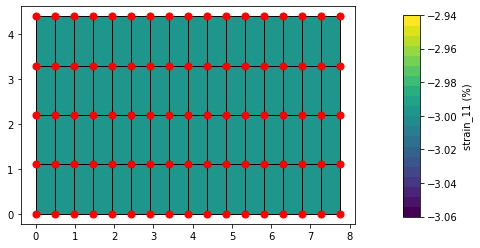

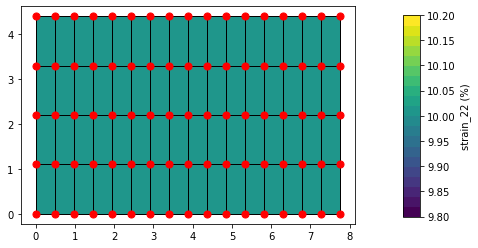

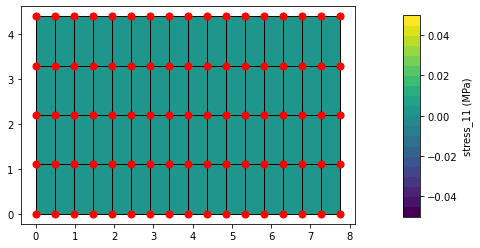

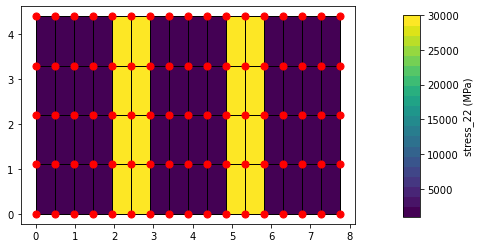

In [1]:
import sys
if ("../source" not in sys.path):
    sys.path.append("../source")

import pyLabFEM as FE
from pyLabMaterial import Material
'laminate model is generated and elastic properties are assigned to each section'
fem_v = FE.Model(dim=2, planestress=True)   # call class to generate container for finite element model
fem_v.geom([2, 1, 2, 1, 2], LY=4.) # define sections in absolute lengths
mat1 = Material()               # call class to generate container for material
mat1.elasticity(E=10.e3, nu=0.3)   # define materials by their elastic propertiess
mat2 = Material()               # define second material
mat2.elasticity(E=300.e3, nu=0.3)
fem_v.assign([mat1, mat2, mat1, mat2, mat1])  # assign the proper material to each section
fmat1 = 6./8.   # calculate volume fraction of each material
fmat2 = 2./8.
'boundary conditions: uniaxial stress in longitudinal direction'
fem_v.bcleft(0.)                     # fix left and bottom boundary
fem_v.bcbot(0.)
fem_v.bcright(0., 'force')           # free boundary condition on right edge of model
fem_v.bctop(0.1*fem_v.leny, 'disp')  # strain applied to top nodes
'solution and evalutation of effective properties'
fem_v.mesh(NX=16, NY=4) # create mesh
fem_v.solve()           # solve system of equations
fem_v.calc_global()     # calculate global stress and strain
mod_stiff = fem_v.glob['sig'][1]/fem_v.glob['eps'][1]     # effective stiffness of numerical model
voigt_stiff = fmat1*mat1.E + fmat2*mat2.E # Voigt stiffness: weighted average of Young's moduli wrt volume fractions
print('2-d Model: isostrain, uniaxial stress, e2=10%')
print('Global strain: ',fem_v.glob['eps'][0].round(decimals=3), fem_v.glob['eps'][1].round(decimals=3))
print('Element strain Section 1: ', fem_v.element[0].eps.round(decimals=3))
print('Element strain Section 2: ', fem_v.element[16].eps.round(decimals=3))
print('Global stress: ',fem_v.glob['sig'][0].round(decimals=3), fem_v.glob['sig'][1].round(decimals=3))
print('Element stress (MPa) Section 1: ', fem_v.element[0].sig.round(decimals=3))
print('Element stress (MPa) Section 2: ', fem_v.element[16].sig.round(decimals=3))
print('Stiffness (MPa): ',mod_stiff)
print('Target (MPa): ', voigt_stiff)
print('Error: ', 1.-mod_stiff/voigt_stiff)
print('----------------------------------------')
fem_v.plot('strain1',mag=1)
fem_v.plot('strain2',mag=1)
fem_v.plot('stress1',mag=1)
fem_v.plot('stress2',mag=1)

It is seen that the isostrain assumption is fulfilled to a very good degree and that the numerical value is identical to that of the analytical Voigt model.

## 3. Laminate model under isostrain conditions (Reuss model)
In the next step, a new model with the identical geometry and materials is generated, but subjected to transversal loading with a uniaxial strain.

2-d Model: isostress, uniaxial strain e1=10%
Global strain:  0.1 0.0
Element strain Section 1:  [0.132 0.    0.    0.    0.    0.   ]
Element strain Section 2:  [ 0.004  0.     0.     0.     0.    -0.   ]
Global stress:  1775.148 760.778
Element stress (MPa) Section 1:  [1775.148  760.778  760.778    0.       0.       0.   ]
Element stress (MPa) Section 2:  [1775.148  760.778  760.778    0.       0.      -0.   ]
Stiffness (MPa):  17751.479289940882
Target (MPa):  17751.479289940828
Error:  -3.1086244689504383e-15
----------------------------------------


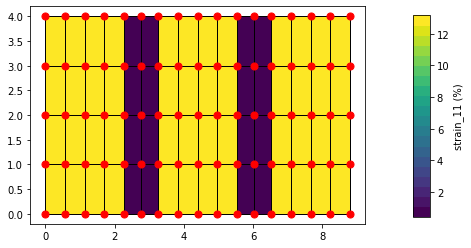

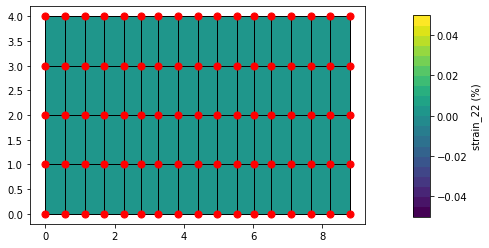

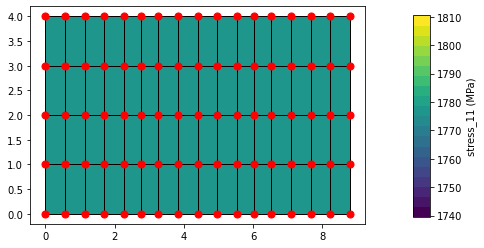

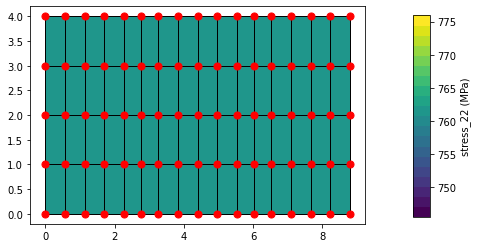

In [2]:
'laminate model is generated and elastic properties are assigned to each section'
fem_r = FE.Model(dim=2)
fem_r.geom([2, 1, 2, 1, 2], LY=4.)            # define sections in absolute lengths
fem_r.assign([mat1, mat2, mat1, mat2, mat1])  # assign the materials to each section
fmat1 = 6./8.   # calculate volume fractions
fmat2 = 2./8.
'mechanical boundary conditions for Reuss model (isostres) with uniaxial strain'
fem_r.bcleft(0.)          # fix left and bottom boundary
fem_r.bcbot(0.)
fem_r.bcright(0.1*fem_r.lenx, 'disp')   # rhs nodes are subject to 10% strain (disp = 0.1 * length of model)
fem_r.bctop(0., 'disp')   # top boundary is fixed
'solution and evaluation of effective properties'
fem_r.mesh(NX=16, NY=4)   # create mesh
fem_r.solve()             # solve equation for mechanical equilibrium
fem_r.calc_global()       # calculate global stress and strain
mod_stiff = fem_r.glob['sig'][0]/fem_r.glob['eps'][0]              # calculate effective stiffness of model
reuss_stiff = 1./(fmat1/mat1.C11 + fmat2/mat2.C11) # Reuss average for stiffness
print('2-d Model: isostress, uniaxial strain e1=10%')
print('Global strain: ',fem_r.glob['eps'][0].round(decimals=3), fem_r.glob['eps'][1].round(decimals=3))
print('Element strain Section 1: ', fem_r.element[0].eps.round(decimals=3))
print('Element strain Section 2: ', fem_r.element[16].eps.round(decimals=3))
print('Global stress: ',fem_r.glob['sig'][0].round(decimals=3), fem_r.glob['sig'][1].round(decimals=3))
print('Element stress (MPa) Section 1: ', fem_r.element[0].sig.round(decimals=3))
print('Element stress (MPa) Section 2: ', fem_r.element[16].sig.round(decimals=3))
print('Stiffness (MPa): ',mod_stiff)
print('Target (MPa): ', reuss_stiff)
print('Error: ', 1.-mod_stiff/reuss_stiff)
print('----------------------------------------')
fem_r.plot('strain1',mag=1)
fem_r.plot('strain2',mag=1)
fem_r.plot('stress1',mag=1)
fem_r.plot('stress2',mag=1)

The Reuss model is well fulfilled for uniaxial strain conditions, where the cross-contraction does not change the geometry of the model. Thus the isostress assumption is valid. Under such uniaxial strain conditions, however, the elastic stiffness $C_{11}$ is the relevant quantity and the calculated numerical value is identical to that calculated by the analytical Reuss model. Now we apply a uniaxial stress, to calculate an effective Young's modulus of the model.

2-d Model: uniaxial stress, e1=10%
Global strain:  0.1 -0.014
Element strain Section 1:  [ 0.138 -0.021 -0.05   0.     0.     0.001]
Element strain Section 2:  [ 0.006 -0.005 -0.     0.     0.     0.   ]
Global stress:  1387.383 0.0
Element stress (MPa) Section 1:  [1447.922  226.668    0.       0.       0.       4.562]
Element stress (MPa) Section 2:  [ 1376.046 -1043.114     0.        0.        0.       23.037]
Stiffness (MPa):  13873.83032469878
Target (MPa):  13186.813186813188
Error:  -0.05209879962299069
----------------------------------------


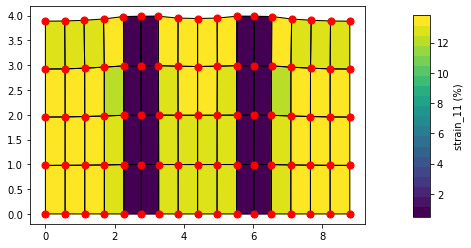

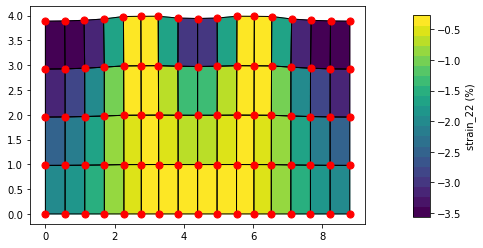

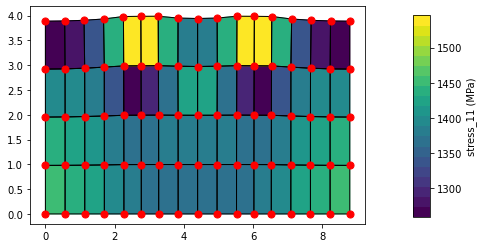

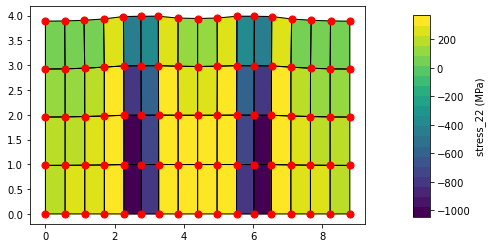

In [3]:
'mechanical boundary conditions changed to uniaxial stress'
fem_r.bctop(0., 'force')  # top boundary is free (other boundary conditions remain in place)
fem_r.planestress = True  # plane stress condition is activated
fem_r.mesh(NX=16, NY=4)   # create mesh
'solution and evaluation of effective properties'
fem_r.solve()             # solve equation for mechanical equilibrium
fem_r.calc_global()       # calculate global stress and strain
mod_stiff = fem_r.glob['sig'][0]/fem_r.glob['eps'][0]          # calculate effective Young's modulus of model
reuss_stiff = 1./(fmat1/mat1.E + fmat2/mat2.E) # Reuss average for Young's modulus
print('2-d Model: uniaxial stress, e1=10%')
print('Global strain: ',fem_r.glob['eps'][0].round(decimals=3), fem_r.glob['eps'][1].round(decimals=3))
print('Element strain Section 1: ', fem_r.element[0].eps.round(decimals=3))
print('Element strain Section 2: ', fem_r.element[16].eps.round(decimals=3))
print('Global stress: ',fem_r.glob['sig'][0].round(decimals=3), fem_r.glob['sig'][1].round(decimals=3))
print('Element stress (MPa) Section 1: ', fem_r.element[0].sig.round(decimals=3))
print('Element stress (MPa) Section 2: ', fem_r.element[16].sig.round(decimals=3))
print('Stiffness (MPa): ',mod_stiff)
print('Target (MPa): ', reuss_stiff)
print('Error: ', 1.-mod_stiff/reuss_stiff)
print('----------------------------------------')
fem_r.plot('strain1',mag=1)
fem_r.plot('strain2',mag=1)
fem_r.plot('stress1',mag=1)
fem_r.plot('stress2',mag=1)

Because of the different strains in both phases, their cross contraction is different, which violates the iso-stress assumption. The effective numerical Young's modulus under these conditions deviates from the Reuss value by 5%.

## 4. Laminate model with different geometrical arrangement of phases
In the next step, we compare composites with identical volume fractions, but different geometry, with only two sections, one for each material. Uniaxial stress is applied and the effective Young's modulus in longitudinal and transversal direction is calculated and compared to the Voigt and Reuss model, respectively.

2-d Model: uniaxial stress, e2=10%
Global strain:  -0.03 0.1
Element strain Section 1:  [-0.03  0.1  -0.03  0.    0.   -0.  ]
Element strain Section 2:  [-0.03  0.1  -0.03  0.    0.   -0.  ]
Global stress:  -0.0 8250.0
Element stress (MPa) Section 1:  [  -0. 1000.    0.    0.    0.   -0.]
Element stress (MPa) Section 2:  [   -0. 30000.     0.     0.     0.    -0.]
Stiffness (MPa):  82499.99999999971
Target (MPa):  82500.0
Error:  3.552713678800501e-15
----------------------------------------


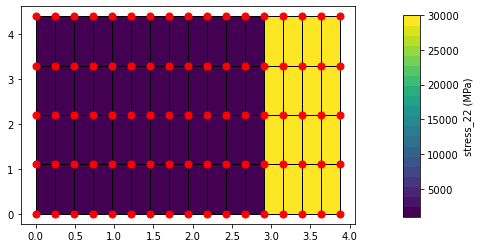

2-d Model: uniaxial stress, e1=10%
Global strain:  0.07 0.08
Element strain Section 1:  [ 0.108  0.068 -0.076  0.     0.     0.   ]
Element strain Section 2:  [-0.024  0.098 -0.032  0.     0.     0.   ]
Global stress:  1360.664 8248.4
Element stress (MPa) Section 1:  [1417.649 1109.695    0.       0.       0.       1.893]
Element stress (MPa) Section 2:  [1.7257220e+03 2.9917944e+04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.6142000e+01]
Stiffness (MPa):  19438.059214283723
Target (MPa):  13186.813186813188
Error:  -0.4740528237498489
----------------------------------------


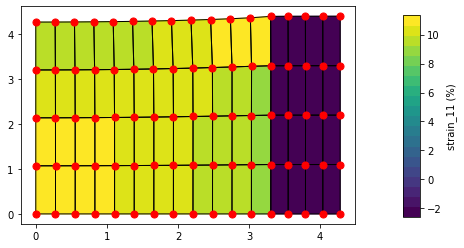

In [4]:
fem = FE.Model(dim=2, planestress=True)
fem.geom([3, 1], LY=4)    # create block geometry
fem.assign([mat1, mat2])  # assign materials to sections
f_1 = 3/4                 # calculate volume fractions
f_2 = 1/4
'boundary conditions for Voigt model'
fem.bcleft(0.)             # fix left and bottom boundary
fem.bcbot(0.)
fem.bcright(0., 'force')   # free right edge
fem.bctop(0.1*fem.leny, 'disp')  # strain applied to top nodes
'solution and evalutation of effective properties'
fem.mesh(NX=16, NY=4)      # create mesh
fem.solve()                # calculate solution
fem.calc_global()          # calculate global stress and strain
mod_stiff = fem.glob['sig'][1]/fem.glob['eps'][1]     # effective Young's modulus of model
voigt_stiff = f_1*mat1.E + f_2*mat2.E # weighted average of Young's moduli wrt volume fractions
print('2-d Model: uniaxial stress, e2=10%')
print('Global strain: ',fem.glob['eps'][0].round(decimals=3), fem.glob['eps'][1].round(decimals=3))
print('Element strain Section 1: ', fem.element[0].eps.round(decimals=3))
print('Element strain Section 2: ', fem.element[fem.Nel-1].eps.round(decimals=3))
print('Global stress: ',fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3))
print('Element stress (MPa) Section 1: ', fem.element[0].sig.round(decimals=3))
print('Element stress (MPa) Section 2: ', fem.element[fem.Nel-1].sig.round(decimals=3))
print('Stiffness (MPa): ',mod_stiff)
print('Target (MPa): ', voigt_stiff)
print('Error: ', 1.-mod_stiff/voigt_stiff)
print('----------------------------------------')
fem.plot('stress2',mag=1)
'boundary conditions for Reuss model'
fem.bctop(0., 'force')             # free top edge
fem.bcright(0.1*fem.lenx, 'disp')  # strain applied to rhs nodes
'solution and evalutation of effective properties'
fem.solve()
fem.calc_global()
mod_stiff = fem.glob['sig'][0]/fem.glob['eps'][0]
reuss_stiff = 1/(f_1/mat1.E + f_2/mat2.E) # weighted average of Young's moduli wrt volume fractions
print('2-d Model: uniaxial stress, e1=10%')
print('Global strain: ',fem.glob['eps'][0].round(decimals=3), fem.glob['eps'][1].round(decimals=3))
print('Element strain Section 1: ', fem.element[0].eps.round(decimals=3))
print('Element strain Section 2: ', fem.element[fem.Nel-1].eps.round(decimals=3))
print('Global stress: ',fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3))
print('Element stress (MPa) Section 1: ', fem.element[0].sig.round(decimals=3))
print('Element stress (MPa) Section 2: ', fem.element[fem.Nel-1].sig.round(decimals=3))
print('Stiffness (MPa): ',mod_stiff)
print('Target (MPa): ', reuss_stiff)
print('Error: ', 1.-mod_stiff/reuss_stiff)
print('----------------------------------------')
fem.plot('strain1',mag=1)

It is seen that the geometrical arragement does not significantly change the results, neither for longitudinal nor for transverse loading.

## 5. Calculation of effective properties as function of volume fraction
The block-like structure is used to calculate the effective elastic properties of the composite as function of the volume fraction.

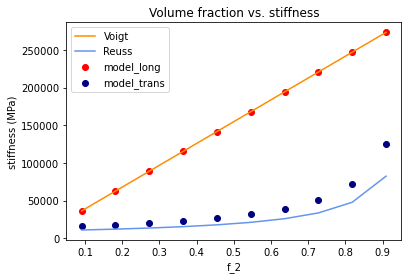

In [5]:
import numpy as np
import matplotlib.pyplot as plt

'initialize arrays for results'
nmax = 10
f_2 = np.zeros(nmax)
E_long  = np.zeros(nmax)
E_trans = np.zeros(nmax)
E_voigt = np.zeros(nmax)
E_reuss = np.zeros(nmax)
for i in range(nmax):
    x = (i+1)/(nmax+1)
    fem.geom([x, 1.-x])
    fem.assign([mat2, mat1])
    f_2[i] = x
    'boundary conditions for Voigt model'
    fem.bcright(0., 'force')   # free right edge
    fem.bctop(0.1*fem.leny, 'disp')  # strain applied to top nodes
    'solution and evalutation of effective properties'
    fem.mesh(NX=nmax*2, NY=4)   # remeshing due to plane stress condition
    fem.solve()
    fem.calc_global()
    E_long[i] = fem.glob['sig'][1]/fem.glob['eps'][1]
    E_voigt[i] = (1-x)*mat1.E + x*mat2.E
    'boundary conditions for Reuss model'
    fem.bcright(0.1*fem.lenx, 'disp')   # strain applied to right edge
    fem.bctop(0., 'force')  # free top nodes
    'solution and evalutation of effective properties'
    fem.solve()
    fem.calc_global()
    E_trans[i] = fem.glob['sig'][0]/fem.glob['eps'][0]
    E_reuss[i] = 1./((1-x)/mat1.E + x/mat2.E)
    
'Graphical output'
plt.scatter(f_2,E_long,color='red', label='model_long')
plt.scatter(f_2,E_trans,color='navy', label='model_trans')
plt.plot(f_2,E_voigt,color='darkorange', label='Voigt')
plt.plot(f_2,E_reuss,color='cornflowerblue', label='Reuss')
plt.xlabel('f_2')
plt.ylabel('stiffness (MPa)')
plt.title('Volume fraction vs. stiffness')
plt.legend()
plt.show()

For volume fractions in the range of 10% to 90% the numerical results agree very well with those of the analytical Voigt and Reuss models, even though the iso-stress condition of the Reuss model is not strictly fulfilled. 